<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.RwandaCO2Emissions/blob/main/0_baseline_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This file DOES NOT contain good code! I use it to practice the skill of pipeline creation and memorizing the sklearn functionality. Refer to the files 1, 2, 3, etc. in the repository for a better documented code.

# Imports

In [111]:
from google.colab import drive

# Datasets
import pandas as pd

# Numerics
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Import module files

In [112]:
%%capture

def download(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}


GIT_URL = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
download(
    {
        file: GIT_URL + file
        for file in [
            'path_manager.py'
        ]
    }
)

In [113]:
import path_manager
import importlib

def reload_all(modules_list):
    for m in modules_list:
        importlib.reload(m)

from path_manager import PathManager

# Mount the drive and setup paths

In [114]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive'

COMPETITION_PATH = f'{gdrive_path}/ML/Competitions/8.CO2Emissions'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1

manager = PathManager(
    COMPETITION_PATH,
    PREPROC_TRIAL,
    MODELS_TRIAL
)

manager.setup_paths()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/ML/Competitions/8.CO2Emissions/Data/preproc_trial_1 already exists
/content/gdrive/MyDrive/ML/Competitions/8.CO2Emissions/Models/trial_1 already exists


# Download the data

In [115]:
train = pd.read_csv(manager.train_path)

# Quick look at the data

In [116]:
train.shape

(79023, 76)

In [117]:
list(train.dtypes)

[dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dt

<Axes: >

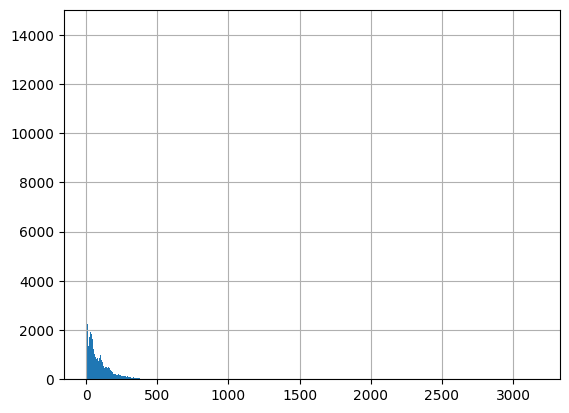

In [118]:
train['emission'].hist(bins=1000)

In [119]:
train['emission'].describe()

count    79023.000000
mean        81.940552
std        144.299648
min          0.000000
25%          9.797995
50%         45.593445
75%        109.549595
max       3167.768000
Name: emission, dtype: float64

In [120]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

# Data cleaning

## Remove outliers in the target

In [121]:
OUTLIER_THRESHOLD = 600

print(train.shape)
train = train.loc[
    train['emission'] <= OUTLIER_THRESHOLD,
    :
]
print(train.shape)

(79023, 76)
(78693, 76)


In [122]:
if 'ID_LAT_LON_YEAR_WEEK' in train.columns:
    train.drop(['ID_LAT_LON_YEAR_WEEK'], axis='columns', inplace=True)
assert 'ID_LAT_LON_YEAR_WEEK' not in train.columns

## Clean columns with high nan percentage

In [123]:
NAN_PERCENTAGE = 0.2

columns_to_remove = []
for c in train.columns:
    n_nans = train[c].isna().sum()
    nan_percent = n_nans / train.shape[0]
    if nan_percent >= NAN_PERCENTAGE:
        columns_to_remove.append(c)

print(train.shape)
train.drop(columns_to_remove, axis='columns', inplace=True)
print(train.shape)

(78693, 75)
(78693, 56)


# Data split

## Split

In [157]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

X = train.loc[:, train.columns != 'emission']
Y = train['emission']
print(X.shape, Y.shape)

X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X,
    Y,
    train_size=0.05,
    random_state=RANDOM_STATE,
    # stratify=Y
)

print(X_trainval.shape, Y_trainval.shape, X_test.shape, Y_test.shape)

(78693, 55) (78693,)
(3934, 55) (3934,) (74759, 55) (74759,)


In [158]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval,
    Y_trainval,
    train_size=0.8,
    random_state=RANDOM_STATE
)

print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(3147, 55) (787, 55) (3147,) (787,)


## Check correct distribution

In [159]:
type(X_trainval), type(X_train)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

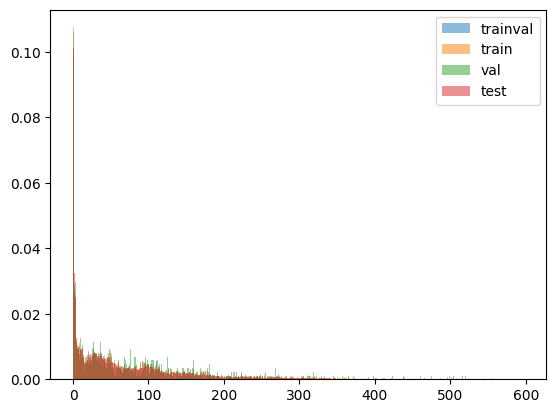

In [160]:
OUTLIER_THRESHOLD = 600

_, ax = plt.subplots()
params = dict(bins=500, density=True, alpha=0.5)
_ = ax.hist(Y_trainval[Y_trainval <= OUTLIER_THRESHOLD], **params, label='trainval')
_ = ax.hist(Y_train[Y_train <= OUTLIER_THRESHOLD], **params, label='train')
_ = ax.hist(Y_val[Y_val <= OUTLIER_THRESHOLD], **params, label='val')
_ = ax.hist(Y_test[Y_test <= OUTLIER_THRESHOLD], **params, label='test')

ax.legend()

# Data processing pipeline

In [161]:
num_columns = X_train.columns.to_list()
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

cat_columns = []
cat_pipeline = make_pipeline()


preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_pipeline, num_columns),
    ]
)

# Model pipeline

In [129]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


pipeline = make_pipeline(
    preprocessor,
    RandomForestRegressor()  # SVR()
)

In [130]:
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'year', 'week_no',
                                                   'SulphurDioxide_SO2_column_number_density',
                                                   'SulphurDioxide_SO2_column_number_density_amf',
                                                   'SulphurDioxide_SO2_slant_column_numbe...
                                                   'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
                                                   'Formaldehyde_HCHO_slant_column_number_density',
                                                   'Formaldehyde_cloud_fraction',
                                                   'Formaldehyde_solar_zenith_angle',
                                                   'Formaldehyde_solar_azimuth_angle',
                                                   'Formaldehyde_sensor_zenith_angle',
                                                   'Formaldehyde_sensor_azimuth_angle',
                                                   'UvAerosolIndex_absorbing_aerosol_index', ...])])),
                ('randomforestregressor', RandomForestRegressor())])

In [131]:
mean_squared_error(
    pipeline.predict(X_train),
    Y_train
)

89.74190171681981

In [133]:
X_train.shape, X_val.shape

((12590, 55), (3148, 55))

In [132]:
mean_squared_error(
    pipeline.predict(X_val),
    Y_val
)

619.6212820077898

# Cross validation gridsearch pipeline

In [162]:
type(X_train)

pandas.core.frame.DataFrame

In [163]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


num_columns = X_train.columns.to_list()
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_columns)
    ]
)

In [174]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

model = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        'n_estimators': [100, 500],
        # 'max_depth': [-1, 3]
    },
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    refit=True,
    cv=2,
    verbose=2,
    # return_train_score=True
)

pipeline = make_pipeline(
    preprocessor,
    model
)

In [175]:
pipeline.fit(
    X_train,
    Y_train,
)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'year', 'week_no',
                                                   'SulphurDioxide_SO2_column_number_density',
                                                   'SulphurDioxide_SO2_column_number_density_amf',
                                                   'SulphurDioxide_SO2_slant_column_numbe...
                                                   'Formaldehyde_solar_zenith_angle',
                                                   'Formaldehyde_solar_azimuth_angle',
                                                   'Formaldehyde_sensor_zenith_angle',
                                                   'Formaldehyde_sensor_azimuth_angle',
                                                   'UvAerosolIndex_absorbing_aerosol_index', ...])])),
                ('gridsearchcv',
                 GridSearchCV(cv=2, estimator=RandomForestRegressor(),
                              n_jobs=-1,
                              param_grid={'n_estimators': [100, 500]},
                              scoring='neg_mean_squared_error', verbose=2))])

In [176]:
from sklearn.metrics import mean_squared_error

def report(model, X, Y):
    print(mean_squared_error(
        model.predict(X), Y
    ))

report(pipeline, X_train, Y_train)

383.3648081521101


In [177]:
report(pipeline, X_val, Y_val)

2895.163829218643


In [178]:
print(pipeline.named_steps['gridsearchcv'].cv_results_)

{'mean_fit_time': array([11.56316078, 65.18592763]), 'std_fit_time': array([0.75203311, 0.72589397]), 'mean_score_time': array([0.08485222, 0.18684936]), 'std_score_time': array([0.00081325, 0.01773572]), 'param_n_estimators': masked_array(data=[100, 500],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 100}, {'n_estimators': 500}], 'split0_test_score': array([-4214.79771176, -4139.47240769]), 'split1_test_score': array([-4639.05833195, -4538.93695163]), 'mean_test_score': array([-4426.92802186, -4339.20467966]), 'std_test_score': array([212.1303101 , 199.73227197]), 'rank_test_score': array([2, 1], dtype=int32)}


In [179]:
print(pipeline.named_steps['gridsearchcv'].best_estimator_)

RandomForestRegressor(n_estimators=500)
